In [1]:
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('paper')
import pandas as pd
from random import randint, seed, uniform
from numpy import random
import numpy as np
import swarms

In [2]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [3]:
contrastsep = np.linspace(0, 1.2, 1000)
contrast = np.ones(1000)*1.e-5

In [4]:
Mmoon = 7.35e22
Mjup = 1.898e27
Rjup = 7.1492e7
AU = 1.496e11
Mearth = 5.972e24
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26

In [6]:
# Mmin = 15 # Mearth (Nep)
# Mmax = 13*318 # Mearth (Jup)
# nvals = 1000
# # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
# # ignore normalization which goes into occurrence. We assume we draw a planet, just 
# # want relative fractions correct
# totoccurrence = 0.5
# Npts = 1000
# alpha = -0.86
# ms = np.linspace(Mmin, Mmax, Npts)
# pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
# cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
# randv = np.random.uniform(size=nvals)
# idxs = np.searchsorted(cumpdf, randv)
# masses = ms[[idx for idx in idxs if idx < len(cumpdf)]]

In [5]:
seed(0)

def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler():
    y = uniform(0, 1)
    return inverse_cdf(y)

def draw_star2(GPI):
    if isinstance(GPI, pd.Series):
        star = GPI
    else:
        idx = randint(0, GPI.shape[0]-1)
        star = GPI.loc[idx]
    return star['Mass']*Msun, star['Lum']*Lsun, star['Fe_H_Teff'], star['Distance_distance']*pc

def draw_star(mean=2., std=1.):
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    return Mstar, Lstar, Tstar, dpl

def draw_planet():
    Mmin = 15 # Mearth (Nep)
    Mmax = 13*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 0.5
    Npts = 1000
    alpha = -0.86
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None, None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = 10# AU
        amax = 200 # AU
        a = loguniform(amin, amax)
        return a*AU, ms[idx]*Mearth 

def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

In [8]:
def sample(GPI):
    Mstar, Lstar, Tstar, d_pl = draw_star()
    apl, Mplt = draw_planet()
    if apl == None:
        return None, None, None, None, None
    
    age = age_sampler()*1e6
    Dc = loguniform(1e5, 1e6) # m
    Mtot = loguniform(0.2, 2)*Mearth#loguniform(1e-4, 1)*Mearth
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.5) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000)
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4/np.pi
    alpha= 1.2  
    #print("dpl: {0:.3e}".format(d_pl)+"\t"+"apl: {0:.3e}".format(apl)+"\t"+"Mpl: {0:.3e}".format(Mplt)+"\t")
    #print("Mstar: {0:.3e}".format(Mstar)+"\t"+"Lstar: {0:.3e}".format(Lstar)+"\t"+"Tstar: {0:.3e}".format(Tstar)+"\t")
    swarm = swarms.CollSwarm(Mtot, Dt, Dmax, Lstar, Mstar, Mplt, apl, R_pl=None, eta=eta, Nstr=Nstr, d_pl=d_pl,
                            rho=rho, fQ=fQ, f_vrel=f_vrel, correction=True, alpha=alpha, Dmin_min=1.25)

    swarm.updateSwarm(age)
   # print("{0:.3e}".format(swarm.computeAtot()))
    swarm_contrast = contrast_scat(swarm.computeAtot(), g, Q, apl)
    Qd = swarm.computeQd(swarm.Dc)
    part1 = (Mstar/1.989e30)**0.33 * f_vrel**0.55
    part2 = (Mplt/5.972e24)**0.06 * Qd**0.15 * eta
    part3 = age * (Mtot/5.972e24) / (rho * (swarm.Dc/1000)) 

    a_opt = 50 * part1 / part2 * part3**0.24 
   # print("sig_tot: {0:.3e}".format(swarm.computeAtot()) + "\t" + "CR: {0:.3e}".format(swarm_contrast)) 
  
    return swarm_contrast, apl/AU, d_pl/pc, Mplt, a_opt

In [9]:
%%time
seed(0)
Nsamples = 600
CR, a, d, Mplt, aopt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CR[i], a[i], d[i], Mplt[i], aopt[i] = sample(GPI)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


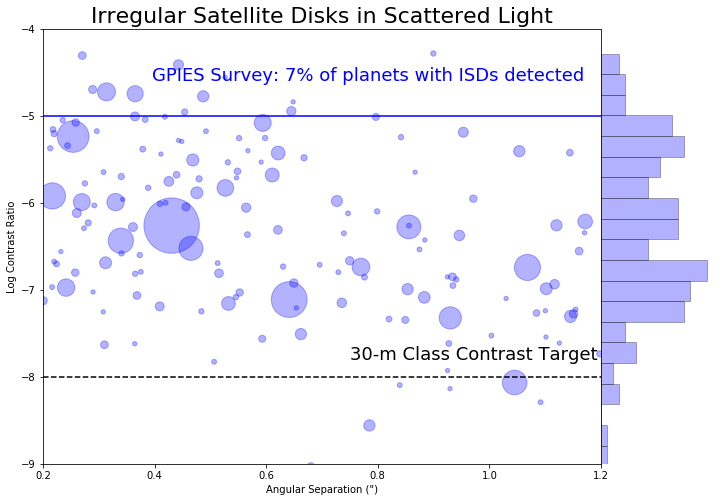

In [10]:
mask = (~np.isnan(CR)) & (a/d > 0.2) & (a/d < 1.2)
cm = plt.cm.get_cmap('RdYlBu')

sep = a[mask]/d[mask]
logCR = np.log10(CR[mask])
Mpltcut = Mplt[mask]

idxs = np.searchsorted(contrastsep, sep)
detectable = np.log10(np.array(contrast)[idxs]) < logCR


fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
axarr[0].scatter(sep, logCR, c='b', s=400*Mpltcut/Mearth/318, alpha=0.3)

axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-9, -4])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].set_title('Irregular Satellite Disks in Scattered Light', fontsize=22)
plt.subplots_adjust(wspace=0)
axarr[0].text(0.395, -4.6, "GPIES Survey: {0:.0f}% of planets with ISDs detected".format(detectable.sum()/len(sep)*100), color='b', fontsize=18)
axarr[0].text(0.75, -7.8, "30-m Class Contrast Target", color='k', fontsize=18)

axarr[1].set_axis_off()
vals, bins, patches = axarr[1].hist(np.log10(CR[mask]), orientation='horizontal', bins=20, facecolor='b', ec='k', alpha=0.3)
fig.savefig('GPIproposaldetections.pdf', bbox_inches='tight')

In [57]:
from math import isnan
import scipy.stats as st
import matplotlib
from fitting import best_fit_distribution, make_pdf

betaprime


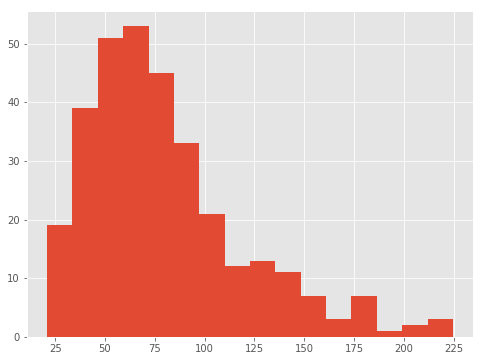

In [58]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.style.use('ggplot')

a_opt_clean = []
for i in range(len(aopt)):
    if not isnan(aopt[i]):
        a_opt_clean.append(aopt[i])

plt.figure()
n, bins, patches = plt.hist(a_opt_clean, bins='auto')

best_fit_name, best_fit_params = best_fit_distribution(a_opt_clean, 200)
print(best_fit_name)
best_dist = getattr(st, best_fit_name)
pdf = make_pdf(best_dist, best_fit_params)

Text(0.5,0,'Distance [AU]')

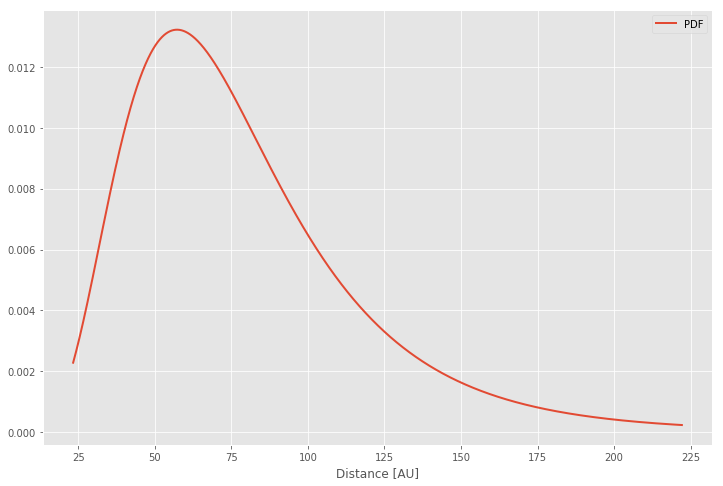

In [59]:
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
ax.set_xlabel("Distance [AU]")
#ax.set_xlabel("Angular Separation (\")")
#ax.set_title("Distance set at 25pc")